In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')

##  developing model families using visual diagnostics and numeric summaries
If you run the user interface code which states input and output format as below, it creates specific model, data, plot (two `.stan`, two `.nc files, multiple plots) in three folders. With minimal number of clicks, your model quality can be inspected. This aim of this vignette is to inspect how given the two outputs (model and data) can be analyzed for your next move.

keyword: simulation-based calibration, pair plots, divergence, InferenceData

## user interface

09:13:49 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data
09:14:03 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data
09:14:03 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
09:14:03 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/draws2data.stan', line 42, column 4: Declaration
    of arrays by pl

chain 1 |          | 00:00 Status

09:14:03 - cmdstanpy - INFO - CmdStan done processing.


09:14:07 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws
09:14:23 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws
09:14:23 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
09:14:23 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan', line 46, column 4: Declaration
    of arrays by pl

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

09:32:30 - cmdstanpy - INFO - CmdStan done processing.
09:32:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan', line 46, column 4 to column 162)
	Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan', line 46, column 4 to column 162)
	Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan', line 46, column 4 to column 162)
	Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R1/data2draws.stan', line 46, column 4 to column 162)
	Exception: ode_rk45: ode parameters and dat

AttributeError: 'list' object has no attribute 'items'

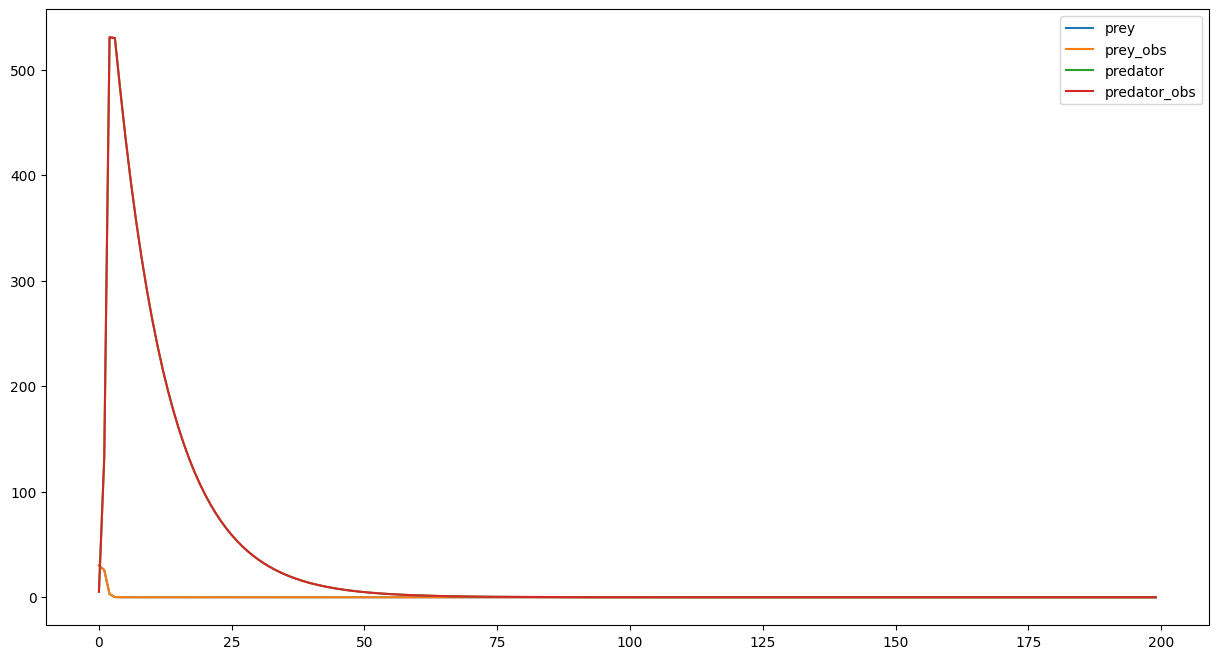

In [3]:
precision ={
    "S": 1, # # of draws from prior
    "M": 100, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 200, # # of observation
    "R": 1, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names": ( "pred_birth_frac"),
    "hier_est_param_names" : (),
    "target_simulated_vector_names": ("prey", "predator"),
    "driving_vector_names": ("process_noise_uniform_driving"),
    "model_name": "prey_predator",
}

numeric = {
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size = precision['N']),
    'process_noise_scale': 0.01
}

prior = {
    ("pred_birth_frac", "normal",  0.9, 0.001, 0),
    ("m_noise_scale", "normal", .01, .001, 0)
}

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/prey_predator/prey_predator.mdl', setting, precision, numeric, prior, output_format)

We load the produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

In [ ]:
draws2data = az.from_netcdf(f"data/{model.name}/draws2data.nc")
data2draws = az.from_netcdf(f"data/{model.name}/data2draws.nc")

## diagnose numerically with InferenceData

`draws2data` have three groups: `prior`, `prior_predictive`, `samp_stats_prior`.First click the arrow to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `prior` group, observed vector for `prior_predictive` group, lp and acceptance rate for `sample_stats_prior` group)

In [ ]:
draws2data


`data2draws` have four groups: `posterior`, `prior_predictive`, `log_likelihood`, `samp_stats`. First click the arrow to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `posterior` group, observed vector (adding measurement noise on target simulated vector posterior) for `prior_predictive` group, loglikelihood of each posterior sample for `log_likelihood`, lp, acceptance_rate, tree_depth, energy (HMC alg.parameters) `sample_stats_prior` group)

In [ ]:
data2draws

summary function returns mean, sd, credible interval for estimated parameter and target simulated vector. mcse, effective sample size (ess), r_hat tells quality of each variables' sample. Refer to [Stan manual](https://mc-stan.org/docs/reference-manual/effective-sample-size.html) for ess details.

In [ ]:
az.summary(data2draws)

## Diagnose visually with time series, trace, pair, rank plots

### time series of target simulated and its measurement noise added observed vector

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharey=True)

for target in ['prey', 'predator']:
    ax1.plot(draws2data.prior[target].mean('prior_draw').to_dataframe().values, label=f"{target}")
ax1.legend(loc= 'upper right')

for target in ['prey', 'predator']:
    ax2.plot(draws2data.prior_predictive[f'{target}_obs'].mean('prior_draw').to_dataframe().values, label=f"{target}_obs")
ax2.legend(loc= 'upper right')


### trace plot
shows estiamted prameters are not well-mixed between chains

In [ ]:
az.plot_trace(data2draws, figsize= (30, 20), var_names= ['pred_birth_frac', 'prey_birth_frac'], kind = "rank_bars")

### pair plot focused and all

In [ ]:
ax = az.plot_pair(data2draws,  var_names=['prey_birth_frac', 'pred_birth_frac'], divergences=True, textsize=22,)

In [ ]:
ax = az.plot_pair(data2draws,  divergences=True, textsize=22,) #, backend="bokeh" for interactive plot

### rank plot
indicates more than one peak

In [ ]:
fig, axes = plt.subplots(1, 2)
az.plot_rank(data2draws, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes)


# Appendix

## model

In [ ]:
print(CmdStanModel(stan_file=f"stan_files/{model.name}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{model.name}/data2draws.stan").code())